In [60]:
import os
import pickle as pkl
import numpy as np
import pandas as pd

In [71]:
result_columns = ['imp', 'dataset', 'metric', 'value',
                  'num_samples', 'num_features', 'noise_stdev',
                  'uncorr_frac', 'seed', 'network_penalty']
results_df = None
results_dir = './param_search_results'
results_dir_nn = './param_search_results/ignore_network'
p_uncorr_frac = 0.5

def parse_pickle(fname, n, p, uncorr_frac, seed, network=True):
    results = []
    with open(fname, 'rb') as f:
        r_map = pkl.load(f)
    for k, v in r_map.items():
        imp, ds, metric = k.split('_')
        results.append([imp, ds, metric, v[0], n, p, noise_stdev,
                        uncorr_frac, seed, network])
    return pd.DataFrame(results, columns=result_columns)
    
# read results from output directory
for fname in os.listdir(results_dir):
    if os.path.isdir(fname): continue
    if 'cv_results' not in fname: continue
    f_sp = os.path.splitext(fname)[0].split('_')
    n = int(f_sp[2].replace('n', ''))
    p = int(f_sp[3].replace('p', ''))
    noise_stdev = float(f_sp[4].replace('e', ''))
    uncorr_frac = float(f_sp[5].replace('u', ''))
    seed = int(f_sp[6].replace('s', ''))
    df = parse_pickle(os.path.join(results_dir, fname),
                      n, p, uncorr_frac, seed)
    if results_df is None:
        results_df = df
    else:
        results_df = pd.concat((results_df, df))
        
for fname in os.listdir(results_dir_nn):
    if os.path.isdir(fname): continue
    if 'cv_results' not in fname: continue
    f_sp = os.path.splitext(fname)[0].split('_')
    n = int(f_sp[2].replace('n', ''))
    p = int(f_sp[3].replace('p', ''))
    noise_stdev = float(f_sp[4].replace('e', ''))
    uncorr_frac = float(f_sp[5].replace('u', ''))
    seed = int(f_sp[6].replace('s', ''))
    df = parse_pickle(os.path.join(results_dir_nn, fname),
                      n, p, uncorr_frac, seed, network=False)
    if results_df is None:
        results_df = df
    else:
        results_df = pd.concat((results_df, df))
    
results_df.head(n=10)

,imp,dataset,metric,value,num_samples,num_features,noise_stdev,uncorr_frac,seed,network_penalty
0,torch,train,rmse,0.868105,100,10,1.0,0.0,2,True
1,torch,train,r2,0.544944,100,10,1.0,0.0,2,True
2,torch,test,rmse,1.038673,100,10,1.0,0.0,2,True
3,torch,test,r2,0.479325,100,10,1.0,0.0,2,True
4,sklearn,train,rmse,0.825931,100,10,1.0,0.0,2,True
5,sklearn,train,r2,0.588085,100,10,1.0,0.0,2,True
6,sklearn,test,rmse,1.242250,100,10,1.0,0.0,2,True
7,sklearn,test,r2,0.255223,100,10,1.0,0.0,2,True
0,torch,train,rmse,0.000305,100,10,0.0,0.5,1,True
1,torch,train,r2,1.000000,100,10,0.0,0.5,1,True


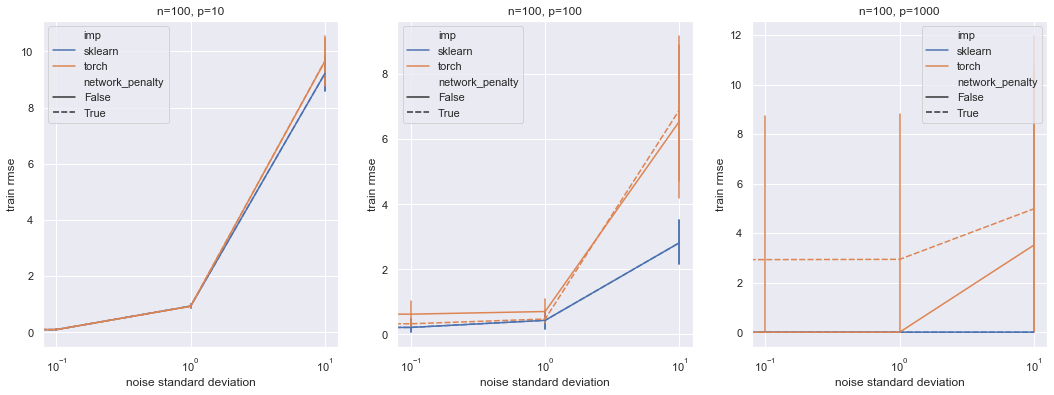

In [72]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
# fig, axarr = plt.subplots(3, 3)
fig, axarr = plt.subplots(1, 3)
fig.set_figwidth(18)
# fig.set_figheight(18)
fig.set_figheight(6)

metric = 'rmse'
# for i, num_samples in enumerate((100, 500, 1000)):
for i, num_samples in enumerate([100]):
    for j, num_feats in enumerate((10, 100, 1000)):
        # ax = axarr[i, j]
        ax = axarr[j]
        filter_df = results_df[(results_df['num_samples'] == num_samples) &
                               (results_df['num_features'] == num_feats) &
                               (results_df['dataset'] == 'train') &
                               (results_df['uncorr_frac'] == p_uncorr_frac) &
                               (results_df['metric'] == metric)]
        filter_df = filter_df.sort_values(by='imp')
        sns.lineplot(data=filter_df, x='noise_stdev', y='value',
                     hue='imp', style='network_penalty', err_style='bars',
                     ax=ax)
        ax.set_title('n={}, p={}'.format(num_samples, num_feats))
        ax.set_xlabel('noise standard deviation')
        ax.set_xscale('log')
        ax.set_ylabel('train {}'.format(metric))
    

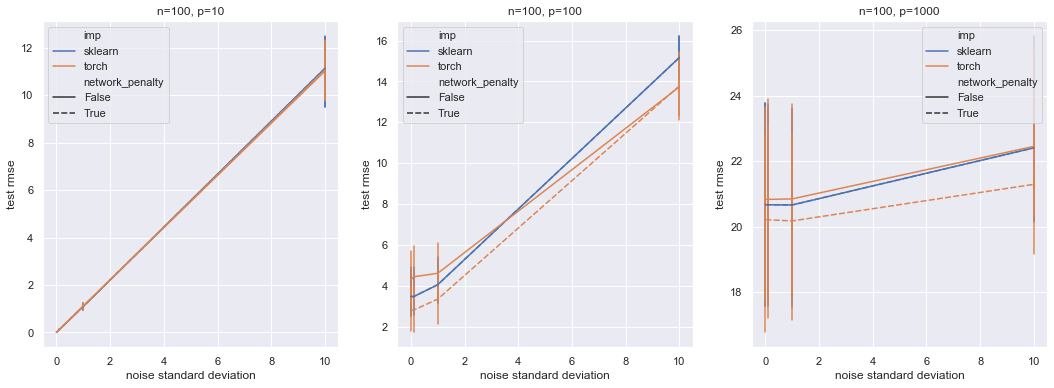

In [73]:
sns.set()
#fig, axarr = plt.subplots(3, 3)
fig, axarr = plt.subplots(1, 3)
fig.set_figwidth(18)
# fig.set_figheight(18)
fig.set_figheight(6)

metric = 'rmse'
# for i, num_samples in enumerate((100, 500, 1000)):
for i, num_samples in enumerate([100]):
    for j, num_feats in enumerate((10, 100, 1000)):
        # ax = axarr[i, j]
        ax = axarr[j]
        filter_df = results_df[(results_df['num_samples'] == num_samples) &
                               (results_df['num_features'] == num_feats) &
                               (results_df['dataset'] == 'test') &
                               (results_df['uncorr_frac'] == p_uncorr_frac) &
                               (results_df['metric'] == metric)]
        filter_df = filter_df.sort_values(by='imp')
        sns.lineplot(data=filter_df, x='noise_stdev', y='value',
                     hue='imp', style='network_penalty', err_style='bars',
                     ax=ax)
        ax.set_title('n={}, p={}'.format(num_samples, num_feats))
        ax.set_xlabel('noise standard deviation')
        ax.set_ylabel('test {}'.format(metric))

In [74]:
result_columns = ['imp', 'metric', 'value', 'num_samples', 
                  'num_features', 'noise_stdev', 'uncorr_frac', 'seed',
                  'network_penalty']
results_df = None

def compile_coefs(results_dir, n, p, noise_stdev, uncorr_frac, seed, network):
    true_coefs = []
    coefs_map = {}
    suffix = 'n{}_p{}_e{}_u{}_s{}.txt'.format(n, p, noise_stdev, uncorr_frac, seed)
    network_file = os.path.join(
        'sim_networks',
        'sim_groups_p{}_e{}_u{}_s{}.tsv'.format(p, noise_stdev, uncorr_frac, seed)
    )
    for fname in os.listdir(results_dir):
        if ('coefs' not in fname) or (suffix not in fname): continue
        imp = fname.split('_')[0]
        coefs = np.loadtxt(os.path.join(results_dir, fname), delimiter='\t',
                           ndmin=1)
        if imp == 'true':
            true_coefs = coefs
        else:
            coefs_map[imp] = coefs
    return calculate_metrics(network_file, true_coefs, coefs_map,
                             n, p, noise_stdev, uncorr_frac, seed,
                             network)

def calculate_metrics(network_file, true_coefs, coefs_map,
                      n, p, noise_stdev, uncorr_frac, seed,
                      network):
    import networkx as nx
    results = []
    # intercept is at the beginning of the list
    G = nx.read_weighted_edgelist(network_file, delimiter='\t')
    for imp, coefs in coefs_map.items():
        l2_loss = calculate_l2_loss(G, coefs)
        l1_loss = calculate_l1_loss(G, coefs)
        true_loss = calculate_true_loss(coefs, true_coefs)
        results.append([imp, 'l2_loss', l2_loss, n, p, noise_stdev,
                        uncorr_frac, seed, network])
        results.append([imp, 'l1_loss', l1_loss, n, p, noise_stdev,
                        uncorr_frac, seed, network])
        results.append([imp, 'true_loss', true_loss, n, p, noise_stdev,
                        uncorr_frac, seed, network])
    return pd.DataFrame(results, columns=result_columns)

def calculate_l2_loss(G, coefs):
    import networkx as nx
    L = nx.laplacian_matrix(G).toarray()
    assert coefs.shape[0]-1 == L.shape[0]
    return coefs[1:].T @ (L @ coefs[1:])

def calculate_l1_loss(G, coefs):
    return sum([abs(coefs[int(i)] - coefs[int(j)]) for (i, j) in G.edges if i != j])

def calculate_true_loss(coefs, true_coefs):
    # truncate in case where some of the coefs are uncorrelated with outcome
    t_coefs = coefs[:true_coefs.shape[0]]
    return sum([abs(t_coefs[i] - true_coefs[i]) for i in range(t_coefs.shape[0])])

# read results from output directory
for fname in os.listdir(results_dir):
    if os.path.isdir(fname): continue
    if 'true_coefs' not in fname: continue
    f_sp = os.path.splitext(fname)[0].split('_')
    n = int(f_sp[2].replace('n', ''))
    p = int(f_sp[3].replace('p', ''))
    noise_stdev = float(f_sp[4].replace('e', ''))
    uncorr_frac = float(f_sp[5].replace('u', ''))
    seed = int(f_sp[6].replace('s', ''))
    df = compile_coefs(results_dir, n, p, noise_stdev,
                       uncorr_frac, seed, network=True)
    if results_df is None:
        results_df = df
    else:
        results_df = pd.concat((results_df, df))
        
# read results from output directory
for fname in os.listdir(results_dir_nn):
    if os.path.isdir(fname): continue
    if 'true_coefs' not in fname: continue
    f_sp = os.path.splitext(fname)[0].split('_')
    n = int(f_sp[2].replace('n', ''))
    p = int(f_sp[3].replace('p', ''))
    noise_stdev = float(f_sp[4].replace('e', ''))
    uncorr_frac = float(f_sp[5].replace('u', ''))
    seed = int(f_sp[6].replace('s', ''))
    df = compile_coefs(results_dir_nn, n, p, noise_stdev,
                       uncorr_frac, seed, network=False)
    if results_df is None:
        results_df = df
    else:
        results_df = pd.concat((results_df, df))
    
results_df.head(n=10)

,imp,metric,value,num_samples,num_features,noise_stdev,uncorr_frac,seed,network_penalty
0,torch,l2_loss,0.002304,100,100,0.0,0.50,1,True
1,torch,l1_loss,16.159870,100,100,0.0,0.50,1,True
2,torch,true_loss,4.707080,100,100,0.0,0.50,1,True
3,sklearn,l2_loss,2.663299,100,100,0.0,0.50,1,True
4,sklearn,l1_loss,16.381700,100,100,0.0,0.50,1,True
5,sklearn,true_loss,10.496160,100,100,0.0,0.50,1,True
0,torch,l2_loss,0.001156,100,1000,0.1,0.75,2,True
1,torch,l1_loss,7.950050,100,1000,0.1,0.75,2,True
2,torch,true_loss,173.613810,100,1000,0.1,0.75,2,True
3,sklearn,l2_loss,1.511710,100,1000,0.1,0.75,2,True


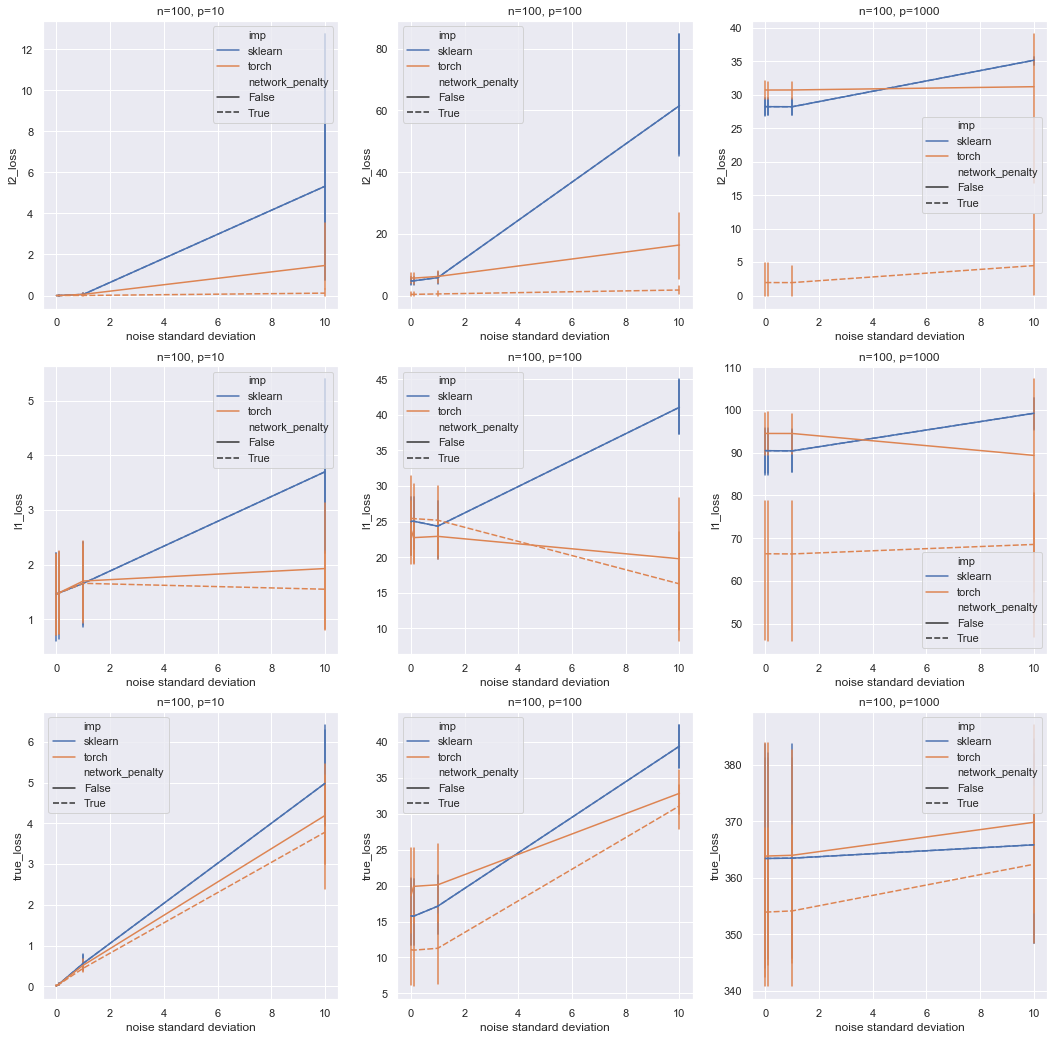

In [75]:
sns.set()
fig, axarr = plt.subplots(3, 3)
fig.set_figwidth(18)
fig.set_figheight(18)

num_samples = 100
for i, metric in enumerate(('l2_loss', 'l1_loss', 'true_loss')):
    for j, num_feats in enumerate((10, 100, 1000)):
        ax = axarr[i, j]
        filter_df = results_df[(results_df['num_samples'] == num_samples) &
                               (results_df['num_features'] == num_feats) &
                               (results_df['uncorr_frac'] == p_uncorr_frac) &
                               (results_df['metric'] == metric)]
        filter_df = filter_df.sort_values(by='imp')
        sns.lineplot(data=filter_df, x='noise_stdev', y='value',
                     hue='imp', style='network_penalty', err_style='bars',
                     ax=ax)
        ax.set_title('n={}, p={}'.format(num_samples, num_feats))
        ax.set_xlabel('noise standard deviation')
        ax.set_ylabel('{}'.format(metric))
    